In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from keras_tuner import RandomSearch
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix, precision_score, recall_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder

np.random.seed(42)
tf.random.set_seed(42)

In [3]:
sliced_df = pd.read_csv('sliced_df.csv')

In [4]:
# Check for missing values in the 'host' column
missing_values = sliced_df['host'].isnull().sum()
print(f"Number of missing values in 'host' column: {missing_values}")


Number of missing values in 'host' column: 0


In [5]:
# Initialize a character-level tokenizer and fit it on the `host` data
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(sliced_df['host'])

# Convert `host` to character sequences
host_sequences = tokenizer.texts_to_sequences(sliced_df['host'])

# Maximum padding lengths: 64 for host
X_host_padded = pad_sequences(host_sequences, maxlen=64, padding='pre')

In [6]:
# Encode `subclass`
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(sliced_df['subclass'])

# Calculate class weights for `subclass` to handle class imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(y_encoded), y=y_encoded)
class_weight_dict = dict(enumerate(class_weights))

print("Class weights:", class_weight_dict)

Class weights: {0: 0.9180328723692719, 1: 1.1721862682433153, 2: 1.0501661268290354, 3: 0.9247816780259754, 4: 1.2751919455309286, 5: 1.0465142544641797, 6: 0.939212312780912, 7: 0.8435292990273585, 8: 0.9670478764309098}


In [7]:
# Function to build the model for Keras Tuner
def build_model(hp):
    model = Sequential()
    model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, 
                        output_dim=hp.Int('embedding_dim', min_value=64, max_value=256, step=64)))
    model.add(Conv1D(filters=hp.Choice('filters', values=[32, 64, 128]), 
                     kernel_size=hp.Choice('kernel_size', values=[3, 5, 7]), 
                     activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(units=hp.Int('units', min_value=64, max_value=256, step=64), activation='relu'))
    model.add(Dropout(hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(Dense(len(np.unique(y_encoded)), activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])), 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

In [8]:
# Initialize the Keras Tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=50,
    executions_per_trial=3,
    directory='model_tuning_sliced_df',
    project_name='cnn_sliced_df_tuning'
)


Reloading Tuner from model_tuning_sliced_df\cnn_sliced_df_tuning\tuner0.json


In [9]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_host_padded, y_encoded, test_size=0.2, random_state=42)

In [10]:
from tensorflow.keras.callbacks import EarlyStopping


# Define Early Stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitors validation loss to stop when it stops improving
    patience=3,  # Number of epochs to wait after no improvement
    restore_best_weights=True  # Restores model weights from the best epoch
)

# Run the hyperparameter search with early stopping
tuner.search(X_train, y_train, epochs=10, validation_split=0.2, class_weight=class_weight_dict, batch_size=32, callbacks=[early_stopping])

In [11]:
# Retrieve the best model
best_model = tuner.get_best_models(num_models=1)[0]

c:\Users\brian\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 16 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [12]:
# Retrieve and Print the Best Hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best Hyperparameters:")
for param, value in best_hyperparameters.values.items():
    print(f"{param}: {value}")

Best Hyperparameters:
embedding_dim: 64
filters: 128
kernel_size: 5
units: 256
dropout: 0.4
learning_rate: 0.001


In [13]:
# Train the model with Early Stopping
history = best_model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=10,  # Number of epochs to run
    batch_size=32,
    callbacks=[early_stopping]  # Add early stopping to the callbacks
)

Epoch 1/10
7043/7043 ━━━━━━━━━━━━━━━━━━━━ 37s 5ms/step - accuracy: 0.8788 - loss: 0.2382 - val_accuracy: 0.8282 - val_loss: 0.3335
Epoch 2/10
7043/7043 ━━━━━━━━━━━━━━━━━━━━ 35s 5ms/step - accuracy: 0.8839 - loss: 0.2311 - val_accuracy: 0.8292 - val_loss: 0.3480
Epoch 3/10
7043/7043 ━━━━━━━━━━━━━━━━━━━━ 40s 6ms/step - accuracy: 0.8873 - loss: 0.2247 - val_accuracy: 0.8341 - val_loss: 0.3693
Epoch 4/10
7043/7043 ━━━━━━━━━━━━━━━━━━━━ 48s 7ms/step - accuracy: 0.8931 - loss: 0.2144 - val_accuracy: 0.8333 - val_loss: 0.3579


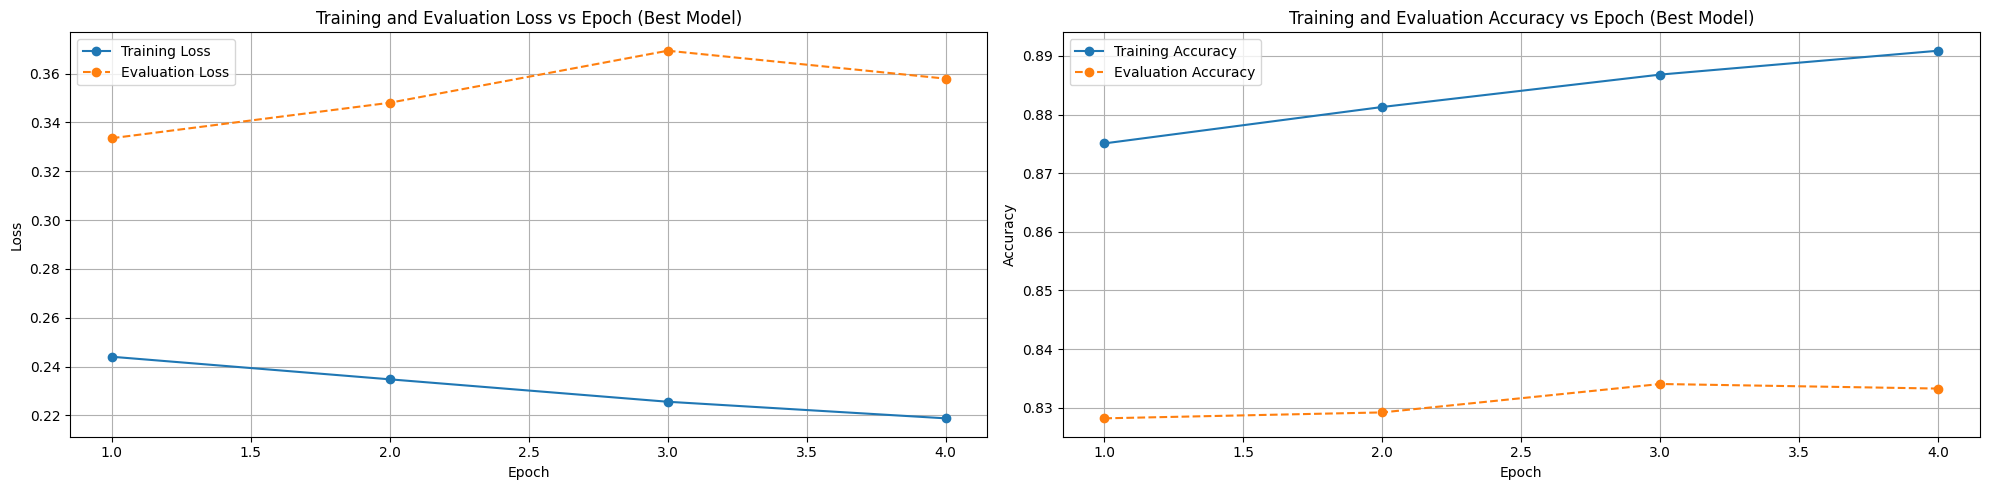

In [34]:
# Extract epochs from the history for plotting
train_epochs = range(1, len(history.history['loss']) + 1)
eval_epochs = train_epochs  # Same epochs for training and validation

# Extract metrics from the history
train_losses = history.history['loss']
eval_losses = history.history['val_loss']
train_accuracies = history.history['accuracy']
eval_accuracies = history.history['val_accuracy']

# Create a side-by-side plot with subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

# Plot Training and Evaluation Loss on the first subplot
ax1.plot(train_epochs, train_losses, label='Training Loss', marker='o')
ax1.plot(eval_epochs, eval_losses, label='Evaluation Loss', marker='o', linestyle='--')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Evaluation Loss vs Epoch (Best Model)')
ax1.legend()
ax1.grid(True)

# Plot Training and Evaluation Accuracy on the second subplot
ax2.plot(train_epochs, train_accuracies, label='Training Accuracy', marker='o')
ax2.plot(eval_epochs, eval_accuracies, label='Evaluation Accuracy', marker='o', linestyle='--')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training and Evaluation Accuracy vs Epoch (Best Model)')
ax2.legend()
ax2.grid(True)

# Adjust layout to minimize whitespace
plt.tight_layout()

# Save the combined plot with minimal whitespace
plt.savefig('training_evaluation_combined.png', dpi=300, bbox_inches='tight')
plt.show()



2201/2201 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


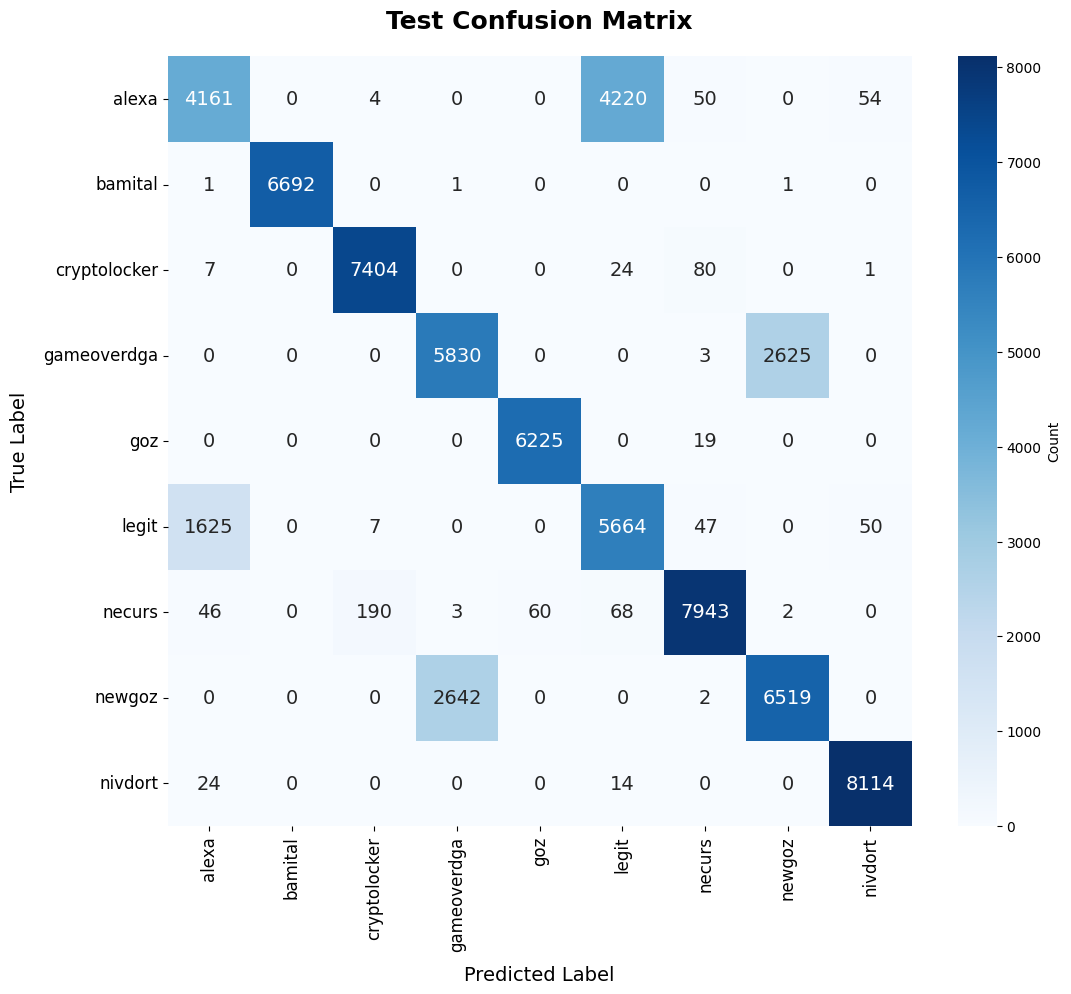

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Generate predictions for the test set
y_pred_class = np.argmax(best_model.predict(X_test), axis=1)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_class)

# Plot the confusion matrix with improved aesthetics
plt.figure(figsize=(12, 10))
heatmap = sns.heatmap(
    conf_matrix,
    annot=True,
    fmt='d',
    cmap='Blues',
    cbar_kws={'label': 'Count'},
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_,
    annot_kws={"size": 14}
)

# Set plot titles and labels with larger fonts
plt.title("Test Confusion Matrix", fontsize=18, fontweight='bold', pad=20)
plt.xlabel("Predicted Label", fontsize=14, labelpad=10)
plt.ylabel("True Label", fontsize=14, labelpad=10)

# Adjust tick label size for readability
heatmap.xaxis.set_tick_params(labelsize=12)
heatmap.yaxis.set_tick_params(labelsize=12, rotation=0)

# Save and show the plot with tighter layout
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()



8803/8803 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step
2201/2201 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


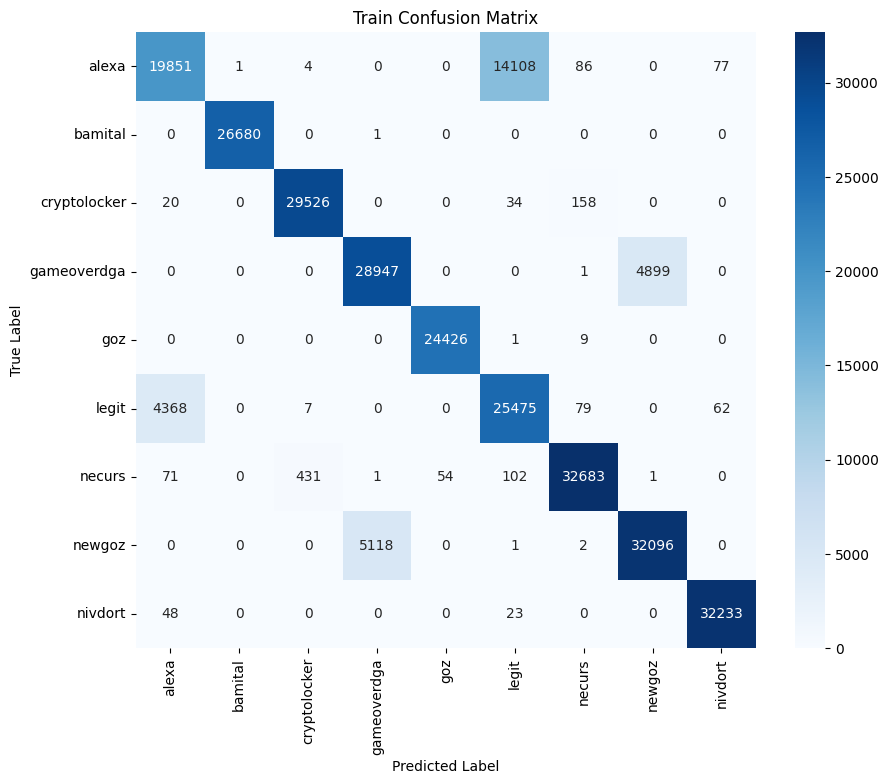

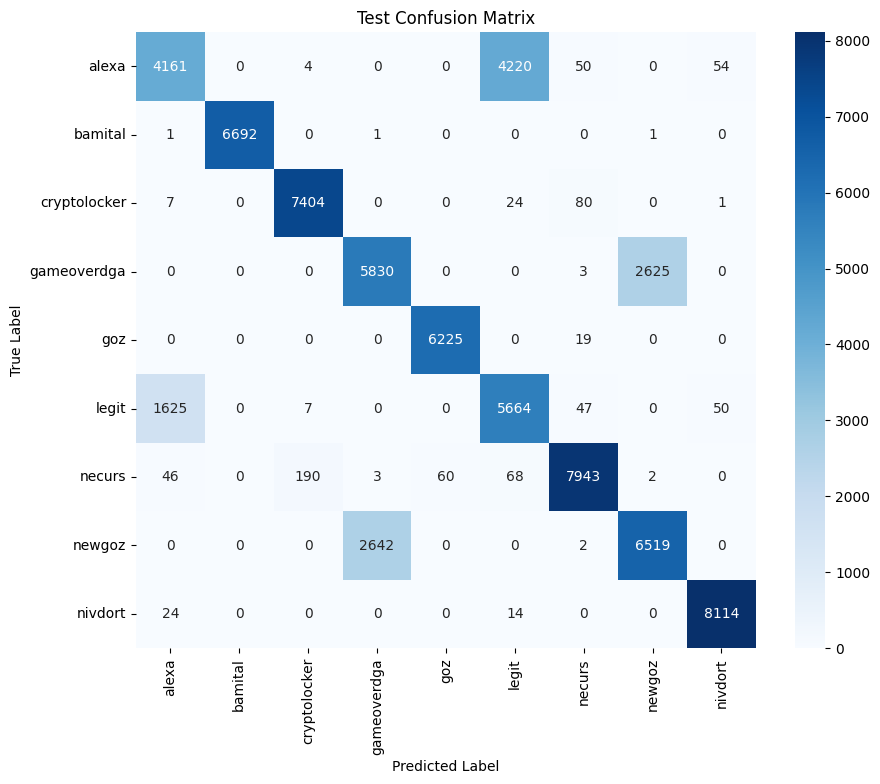

In [17]:
# Predict class labels for training and test sets
y_train_pred_class = np.argmax(best_model.predict(X_train), axis=1)
y_test_pred_class = np.argmax(best_model.predict(X_test), axis=1)

# Generate and plot confusion matrices for train and test sets
splits = {'Train': (y_train, y_train_pred_class), 'Test': (y_test, y_test_pred_class)}

for split, (y_true, y_pred) in splits.items():
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title(f"{split} Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

In [18]:
# Initialize OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)

# Function to compute ROC-AUC for the test set
true_one_hot = encoder.fit_transform(np.array(y_test).reshape(-1, 1))
predicted_one_hot = encoder.transform(np.array(y_pred_class).reshape(-1, 1))
test_roc_auc = roc_auc_score(true_one_hot, predicted_one_hot, average="macro", multi_class="ovo")

# Print the ROC-AUC score for the test set
print('Test ROC-AUC Score:', test_roc_auc)


Test ROC-AUC Score: 0.9110441989955747


In [19]:
# Calculate and print metrics for the test set
accuracy = accuracy_score(y_test, y_pred_class)
precision = precision_score(y_test, y_pred_class, average='weighted')
recall = recall_score(y_test, y_pred_class, average='weighted')
f1 = f1_score(y_test, y_pred_class, average='weighted')

print("Test Metrics:")
print(f"  Accuracy: {accuracy:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall: {recall:.4f}")
print(f"  F1 Score: {f1:.4f}\n")

Test Metrics:
  Accuracy: 0.8314
  Precision: 0.8366
  Recall: 0.8314
  F1 Score: 0.8300



In [20]:
from sklearn.metrics import accuracy_score

# Function to compute multiclass macro accuracy
def multiclass_macro_accuracy(y_true, y_pred):
    # Get the unique classes in the data
    unique_classes = np.unique(y_true)
    
    # Calculate accuracy for each class
    class_accuracies = []
    for cls in unique_classes:
        # Mask to identify instances of the current class
        class_mask = y_true == cls
        
        # Accuracy for the current class
        class_accuracy = accuracy_score(y_true[class_mask], y_pred[class_mask])
        class_accuracies.append(class_accuracy)
    
    # Macro accuracy is the average of individual class accuracies
    macro_accuracy = np.mean(class_accuracies)
    return macro_accuracy

# Compute and print the multiclass macro accuracy
macro_accuracy = multiclass_macro_accuracy(y_test, y_pred_class)
print(f"Multiclass Macro Accuracy for 'subclass': {macro_accuracy:.4f}")


Multiclass Macro Accuracy for 'subclass': 0.8433


In [21]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_class))

              precision    recall  f1-score   support

           0       0.71      0.49      0.58      8489
           1       1.00      1.00      1.00      6695
           2       0.97      0.99      0.98      7516
           3       0.69      0.69      0.69      8458
           4       0.99      1.00      0.99      6244
           5       0.57      0.77      0.65      7393
           6       0.98      0.96      0.97      8312
           7       0.71      0.71      0.71      9163
           8       0.99      1.00      0.99      8152

    accuracy                           0.83     70422
   macro avg       0.84      0.84      0.84     70422
weighted avg       0.84      0.83      0.83     70422



## Binary

In [22]:
from sklearn.preprocessing import LabelBinarizer

# Convert to binary problem for evaluation
positive_classes = ['legit', 'alexa']  # Replace these with the actual class labels for legit and alexa
positive_class_indices = [i for i, label in enumerate(label_encoder.classes_) if label in positive_classes]

def convert_to_binary(y_true, y_pred, positive_class_indices):
    y_true_binary = np.isin(y_true, positive_class_indices).astype(int)
    y_pred_binary = np.isin(y_pred, positive_class_indices).astype(int)
    return y_true_binary, y_pred_binary

In [23]:
# Convert train and test predictions to binary
y_train_binary_true, y_train_binary_pred = convert_to_binary(y_train, y_train_pred_class, positive_class_indices)
y_test_binary_true, y_test_binary_pred = convert_to_binary(y_test, y_test_pred_class, positive_class_indices)


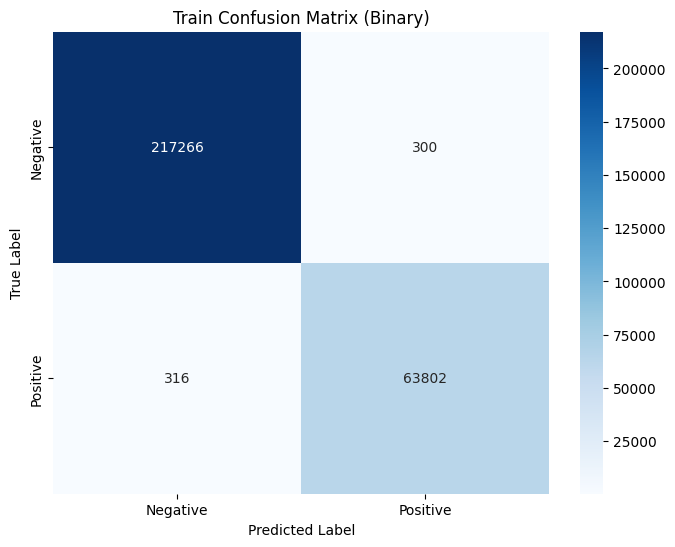

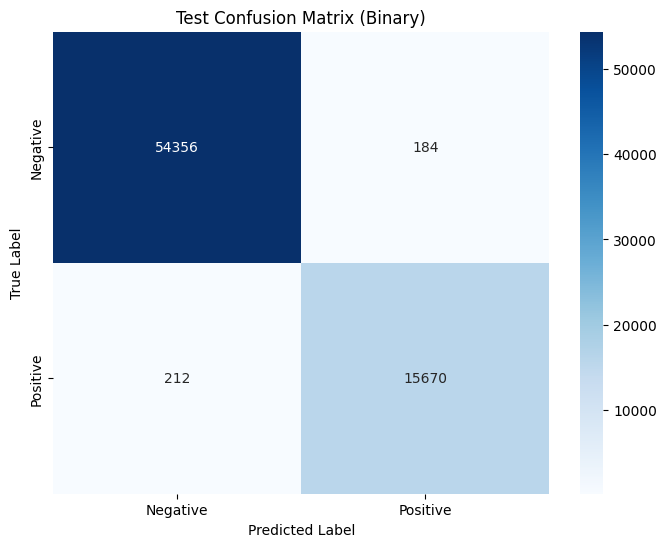

In [24]:
# Generate and plot confusion matrices for binary classification
splits_binary = {'Train': (y_train_binary_true, y_train_binary_pred), 'Test': (y_test_binary_true, y_test_binary_pred)}

for split, (y_true, y_pred) in splits_binary.items():
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.title(f"{split} Confusion Matrix (Binary)")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

In [ ]:
# Calculate and print binary metrics for the test set
accuracy = accuracy_score(y_test_binary_true, y_test_binary_pred)
precision = precision_score(y_test_binary_true, y_test_binary_pred)
recall = recall_score(y_test_binary_true, y_test_binary_pred)
f1 = f1_score(y_test_binary_true, y_test_binary_pred)
roc_auc = roc_auc_score(y_test_binary_true, y_test_binary_pred)

print("Binary Test Metrics:")
print(f"  Accuracy: {accuracy:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall: {recall:.4f}")
print(f"  F1 Score: {f1:.4f}")
print(f"  ROC-AUC Score: {roc_auc:.4f}\n")

Binary Test Metrics:
  Accuracy: 0.9944
  Precision: 0.9884
  Recall: 0.9867
  F1 Score: 0.9875
  ROC-AUC Score: 0.9916



In [27]:
from sklearn.metrics import confusion_matrix

def true_negative_rate(y_true, y_pred):
    # Generate the confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    # Calculate TNR
    tnr = tn / (tn + fp)
    return tnr

# Calculate and print the True Negative Rate for the binary test set
tnr_test = true_negative_rate(y_test_binary_true, y_test_binary_pred)
print(f"True Negative Rate (TNR) for Test Set: {tnr_test:.4f}")


True Negative Rate (TNR) for Test Set: 0.9966
